In [21]:

from scipy.stats.qmc import LatinHypercube as LHS, Sobol, scale
from scipy.integrate import quad, dblquad, tplquad, nquad
from matplotlib import cm, pyplot as plt
import numpy as np
from src.utils import *
import json
from math import floor, ceil
from src.fancyplotter import usePlotSampleSet, SampleSetPlot
from typing import Callable, Generator
from latinexpansion import grade, eLHS
import ipywidgets as ws 
from time import time
from IPython.display import clear_output
from copy import deepcopy as dc

err = 1e-9


# EXPERIMENT I

Datasets for experiment 1 and further experiments.

In [68]:
N = 500
Ptot = 2
K = 3
step = 5
Mmax = K * N + 1
n_agents = 5
ms = np.array(list(np.arange(step, Mmax, step)), dtype=int)

exp1_baseLHS = np.array([LHS(Ptot).random(N) for _ in range(n_agents)])
exp1_baseMC = np.array([MC(Ptot).random(N) for _ in range(n_agents)])
exp1_baseSobol = np.array([Sobol(Ptot).random(N) for _ in range(n_agents)])


def raddons():
    mc = MC(Ptot)
    return np.array([[mc.random(step) for _ in ms] for i in range(n_agents)])

exp1_agents = {
    "eLHS": {
        "initial": exp1_baseLHS,
        "addons": []
    },
    "eLHS-F": {
        "initial": exp1_baseLHS,
        "addons": []
    },
    "LHS": {
        "initial": exp1_baseLHS,
        "addons": raddons()
    },
    "MC": {
        "initial": exp1_baseMC,
        "addons": raddons()
    },
    "Sobol": {
        "initial": exp1_baseSobol,
        "addons": raddons()
    }
}


exp1_agents["eLHS-F"]["addons"] = np.zeros((n_agents, len(ms), step, Ptot))

for i in range(n_agents):
    exp1_agents["eLHS-F"]["addons"][i, 0] = eLHS(exp1_agents["eLHS-F"]["initial"][i], ms[0])
    for mindex in range(1, len(ms)):
        exp1_agents["eLHS-F"]["addons"][i, mindex] = eLHS(
            np.concatenate((exp1_agents["eLHS-F"]["initial"][i], 
                            *exp1_agents["eLHS-F"]["addons"][i, :mindex])), step)

exp1_results = {
    "eLHS": np.zeros((n_agents, len(ms))),
    "eLHS-F": np.zeros((n_agents, len(ms))),
    "LHS": np.zeros((n_agents, len(ms))),
    "MC": np.zeros((n_agents, len(ms))),
    "Sobol": np.zeros((n_agents, len(ms))),
    "__ms": ms
}

# exp1_results = {}

/Users/alessandro/anaconda3/envs/lab/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


## EXPERIMENT 1.1

In [91]:
# P100experiment_agents = exp1_agents
# P100experiment_results = exp1_results
########
# exp1_agents = P100experiment_agents
# exp1_results = P100experiment_results

In [69]:
for i in range(n_agents):
    exp1_results["eLHS"][i, 0] = grade(exp1_agents["eLHS"]["initial"][i])
    exp1_results["eLHS-F"][i, 0] = grade(exp1_agents["eLHS-F"]["initial"][i])
    exp1_results["LHS"][i, 0] = grade(exp1_agents["LHS"]["initial"][i])
    exp1_results["MC"][i, 0] = grade(exp1_agents["MC"]["initial"][i])
    exp1_results["Sobol"][i, 0] = grade(exp1_agents["Sobol"]["initial"][i])
    for mindex in range(1, len(ms)):
        M = ms[mindex]
        exp1_results["eLHS"][i, mindex] = grade(exp1_agents["eLHS"]["initial"][i], M) + M/(N+M)
        exp1_results["eLHS-F"][i, mindex] = grade(np.concatenate((exp1_agents["eLHS-F"]["initial"][i], *exp1_agents["eLHS-F"]["addons"][i, :mindex])))
        exp1_results["LHS"][i, mindex] = grade(np.concatenate((exp1_agents["LHS"]["initial"][i], *exp1_agents["LHS"]["addons"][i, :mindex])))
        exp1_results["MC"][i, mindex] = grade(np.concatenate((exp1_agents["MC"]["initial"][i], *exp1_agents["MC"]["addons"][i, :mindex])))
        exp1_results["Sobol"][i, mindex] = grade(np.concatenate((exp1_agents["Sobol"]["initial"][i], *exp1_agents["Sobol"]["addons"][i, :mindex])))
    print("done:",str(i))


done: 0
done: 1
done: 2
done: 3
done: 4


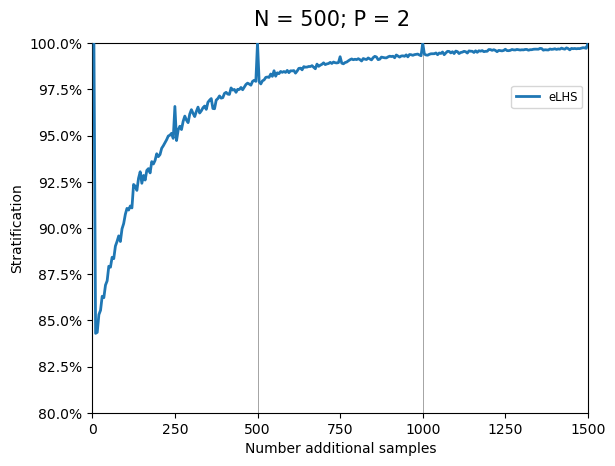

In [96]:

exp1_plots = {
    "eLHS": np.average(exp1_results["eLHS"], axis=0),
    "eLHS-F": np.average(exp1_results["eLHS-F"],axis=0),
    "LHS": np.average(exp1_results["LHS"],axis=0),
    "MC": np.average(exp1_results["MC"],axis=0),
    "Sobol": np.average(exp1_results["Sobol"],axis=0),
    "__ms": ms
}

lw = 2
plt.plot(ms, exp1_plots["eLHS"], linewidth=lw, label="eLHS", zorder=10)
# plt.plot(ms, exp1_plots["eLHS-F"], linewidth=lw, label="eLHS-F")
# plt.plot(ms, exp1_plots["LHS"], linewidth=lw, label="LHS")
# plt.plot(ms, exp1_plots["MC"], linewidth=lw, label="MC")
# plt.plot(ms, exp1_plots["Sobol"], linewidth=lw, label="Sobol", zorder=0)
plt.ylim(0.80, 1)
plt.xlim(0, Mmax)
plt.xlabel("Number additional samples")
plt.ylabel("Stratification")
plt.suptitle('N = ' + str(N) + '; P = ' + str(Ptot), fontsize=15, y=0.95)
# plt.axhline(1.0, color='red', linestyle='-', linewidth = 1.0, label = "Perfect Expansion")
plt.xticks(ticks=np.arange(0, Mmax, 250))
yticks = np.arange(0.80, 1.025, 0.025)
plt.yticks(ticks=yticks, labels=np.char.add(np.round(yticks * 100, 2).astype(str), "%"))
for K in range(1, K + 1):
    plt.axvline(K * N, color='grey', linestyle='-', linewidth = 0.5)
plt.legend(bbox_to_anchor=(0.5, 0.4, 0.5, 0.5), fontsize='small')
# plt.savefig("./data/plots/exp1.1.P_" + str(Ptot) + ".png", dpi=500)
plt.show()

## Experiment 1.3

In [ ]:
def get_agents_with_P_axes(P):
    return exp2agents[P - Pmin]

N = 200
Pmin, Pmax = 2, 100
n_agents = 5

exp2agents = [
    [LHSampler(d=p).random(N) for _ in range(n_agents)] 
        for p in range(Pmin, Pmax+1)
]

In [ ]:
K = 3  # M ranges from N to K*N
ms = np.array(range(0, K*N + 1), dtype=int)
ps = list(range(Pmin, Pmax+1))
ys = []
elapsed_times = []
for p in ps:
    def sectionize(M):
        avg = 0 
        for i in range(n_agents):
            avg += grade(
                get_agents_with_P_axes(p)[i],
            M) + M/(N+M)
        avg /= n_agents
        return avg

    p_section = np.vectorize(sectionize)
    t = time()
    ys.append(p_section(ms))
    t = time() - t
    elapsed_times.append(t)
    clear_output(wait=True)
    print("P = ", p, " | elapsed time = ", t)

ys = np.array(ys)
X, Y = np.meshgrid(ms, ps)

#filtering out perfect expansions
perfectmask = (ys[0] != 1.0)
Xfiltered, Yfiltered = X[:, perfectmask], Y[:, perfectmask]
ysfiltered = ys[:, perfectmask]
print("DONE")

In [ ]:
elev, azim = 20, 20
# plot3d(X, Y, ys, elev=elev, azim=azim, save=False)
plot3d(Xfiltered, Yfiltered, ysfiltered, elev=elev, azim=azim, save=True)

### Directional derivatives to check eLHS tendency of getting better/worst based on number of P axis

In [ ]:
def prime_der(ys: np.ndarray):
    return [ys[i+1] - ys[i] for i in range(len(ys)-1)]

m_stepper = np.linspace(0, ysfiltered.shape[1]-1, 15, dtype=int)
for m in m_stepper:
    plt.plot(ps, np.log(ysfiltered[:, m]))
plt.show()

for m in m_stepper:
    plt.plot(ps[:-1], prime_der(ysfiltered[:, m]))
plt.show()


# EXPERIMENT II
Monte-Carlo Integration accuracy

In [2]:
def l(x, y, z):
    return x**2 * y + y**2 * z + z**2 * x

def g(x, y, z):
    return np.exp(-x**2 - y**2 - z**2) * np.sin(x) * np.cos(y) * np.sin(z)

def h(x, y, z):
    return (x**2 + y**2 + z**2) / ((1 + x**2) * (1 + y**2) * (1 + z**2))

def k(x, y, z):
    return (x * np.sin(y) + y * np.cos(z) + z * np.sin(x)) * (x + y**2 + z**3)

# Define the integration bounds
bounds_x = [0, 1]
bounds_y = [0, 1]
bounds_z = [0, 1]
l_bounds = [bounds_x[0], bounds_y[0], bounds_z[0]]
u_bounds = [bounds_x[1], bounds_y[1], bounds_z[1]]

V = (bounds_x[1] - bounds_x[0]) * (bounds_y[1] - bounds_y[0]) * (bounds_y[1] - bounds_y[0])

# Integrate the functions over the specified bounds
integral_l, _ = nquad(l, [bounds_z, bounds_y, bounds_x])
integral_g, _ = nquad(g, [bounds_z, bounds_y, bounds_x])
integral_h, _ = nquad(h, [bounds_z, bounds_y, bounds_x])
integral_k, _ = nquad(k, [bounds_z, bounds_y, bounds_x])

In [56]:

Nstart, Nmax, step, iter = 100, 10000, 50, 20
ns = np.arange(Nstart, Nmax, step)

def fun(v):
    x, y, z = v
    return g(x, y, z)

lhs_agent = LHSampler(d=3)

def elhs_agent(S, M):
    if M == 0: 
        return S
    else:
        # return LHS(3).random(len(S), M)
        return concat(S, eLHS(S, M))

def get_exec_time(t, iteration_number = iter):
    # return (time() - t)/(1000 * iteration_number)
    return time() - t


initial_Ss = [lhs_agent.random(Nstart) for _ in range(iter)]
perfres = integral_g
elapsed_times_lhs = np.zeros((len(ns), 2), dtype=object)
elapsed_times_elhs = np.zeros((len(ns), 2), dtype=object)
elapsed_times_elhsf = np.zeros((len(ns), 2), dtype=object)

exp3data = np.zeros((len(ns), 4), dtype=object)
for i in range(len(ns)):
    exp3data[i] = [ns[i], 0, 0, 0]


## for eLHS-F
xselhsf = dc(initial_Ss)

t = time()
labor = np.zeros(iter)
ssprev = []
for j in range(iter):
    ssprev.append(dc(xselhsf[j]))
    xselhsf[j] = scale(xselhsf[j], l_bounds, u_bounds)
    labor[j] = MCSim(fun, xselhsf[j], V)
elapsed_times_elhsf[0] = [Nstart, get_exec_time(t)]
exp3data[0, 3] = labor


for i in range(1, len(ns)):
    labor = np.zeros(iter)
    for j in range(iter):
        xselhsf[j] = eLHS(ssprev[j], step)
        ssprev[j] = np.concatenate((ssprev[j], dc(xselhsf[j])))
        xselhsf[j] = scale(xselhsf[j], l_bounds, u_bounds)
        labor[j] = (
            (ns[i-1]/(ns[i])) * exp3data[i-1, 3][j] + 
            (V/(ns[i])) * np.sum(np.apply_along_axis(fun, 1, xselhsf[j]))
        )
    elapsed_times_elhsf[i] = [ns[i], get_exec_time(t)]
    exp3data[i, 3] = labor
print("DONE: eLHS-F ")


## for eLHS
t = time()
for i in range(len(ns)):
    labor = np.zeros(iter)
    for j in range(iter):
        xselhs = elhs_agent(initial_Ss[j], ns[i] - Nstart)
        xselhs = scale(xselhs, l_bounds, u_bounds)
        # labor[j]= MCSim(fun, xselhs, V)
        labor[j]= V * np.mean(np.apply_along_axis(fun, 1, xselhs))
    elapsed_times_elhs[i] = [ns[i], get_exec_time(t)]
    exp3data[i, 2] = labor
print("DONE: eLHS")


## for LHS
t = time()
labor = np.zeros(iter)
for j in range(iter):
    xslhs = dc(initial_Ss[j])
    xslhs = scale(xslhs, l_bounds, u_bounds)
    labor[j] = MCSim(fun, xslhs, V)
elapsed_times_lhs[0] = [ns[0], get_exec_time(t)]
exp3data[0, 1] = labor

for i in range(1, len(ns)):
    labor = np.zeros(iter)
    for j in range(iter):
        xslhs = lhs_agent.random(ns[i])
        xslhs = scale(xslhs, l_bounds, u_bounds)
        # labor[j] = MCSim(fun, xslhs, V)
        labor[j]= V * np.mean(np.apply_along_axis(fun, 1, xslhs))
    elapsed_times_lhs[i] = [ns[i], get_exec_time(t)]
    exp3data[i, 1] = labor
print("DONE: LHS ")



DONE: eLHS-F 
DONE: eLHS
DONE: LHS 


In [28]:

# ## for eLHS-F
# xselhsf = []
# for j in range(iter):
#     xselhsf.append(initial_Ss[j])

# t = time()
# labor = np.zeros(iter)
# for j in range(iter):
#     xselhsf[j] = scale(initial_Ss[j], l_bounds, u_bounds)
#     labor[j] = MCSim(fun, xselhsf[j], V)
# elapsed_times_elhsf[i] = [Nstart, get_exec_time(t)]
# exp3data[0, 3] = labor

# ssprev = initial_Ss
# for i in range(1, len(ns)):
#     labor = np.zeros(iter)
#     for j in range(iter):
#         # xselhsf[j] = eLHS(ssprev[j], ns[i] - Nstart)
#         xselhsf[j] = eLHS(ssprev[j], step)
#         ssprev[j] = np.concatenate((ssprev[j], xselhsf[j]))
#         xselhsf[j] = scale(xselhsf[j], l_bounds, u_bounds)
#         labor[j] = (
#             (ns[i-1]/(ns[i])) * exp3data[0, 3][j] + 
#             (V/(ns[i])) * np.sum(np.apply_along_axis(fun, 1, xselhsf[j]))
#         )
#     elapsed_times_elhsf[i] = [ns[i], get_exec_time(t)]
#     exp3data[i, 3] = labor
# print("DONE: eLHS-F ")

# # ## for LHS
# # t = time()
# # labor = np.zeros(iter)
# # for j in range(iter):
# #     xslhs = initial_Ss[j]
# #     xslhs = scale(xslhs, l_bounds, u_bounds)
# #     labor[j] = MCSim(fun, xslhs, V)
# # elapsed_times_lhs[0] = [ns[0], get_exec_time(t)]
# # exp3data[0, 1] = labor

# # for i in range(1, len(ns)):
# #     labor = np.zeros(iter)
# #     for j in range(iter):
# #         xslhs = lhs_agent.random(ns[i])
# #         xslhs = scale(xslhs, l_bounds, u_bounds)
# #         labor[j] = MCSim(fun, xslhs, V)
# #     elapsed_times_lhs[i] = [ns[i], get_exec_time(t)]
# #     exp3data[i, 1] = labor
# # print("DONE: LHS ")

DONE: eLHS-F 


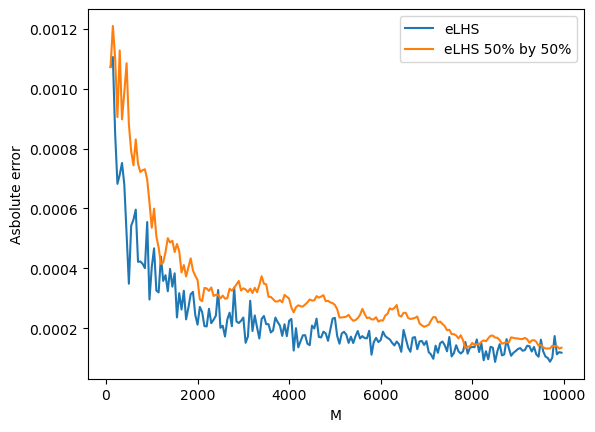

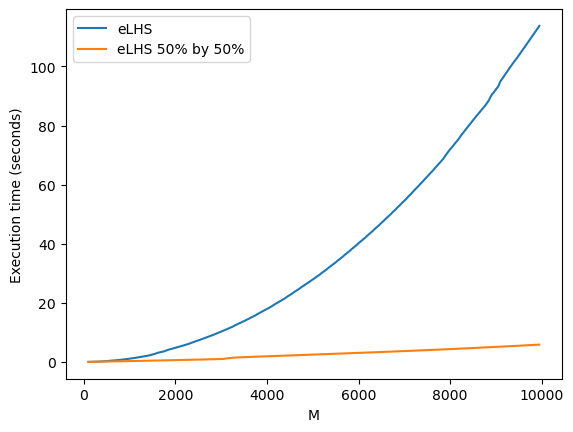

In [66]:

accrate = np.zeros((len(ns), 4))

for i in range(len(ns)):
    accrate[i] = [exp3data[i][0], 
                  np.average(np.abs(perfres - exp3data[i][1])), 
                  np.average(np.abs(perfres - exp3data[i][2])),
                  np.average(np.abs(perfres - exp3data[i][3]))]
# plt.plot(accrate[:,0], accrate[:,1], label="Random-LHS", zorder=0)
plt.plot(accrate[:,0], accrate[:,2], label="eLHS", zorder=5)
plt.plot(accrate[:,0], accrate[:,3], label="eLHS 50% by 50%", zorder=10)
plt.xlabel("M")
plt.ylabel("Asbolute error")
plt.legend()
# plt.savefig("./data/plots/exp2.mcaccuracy.N_100_to_10000.v2.png", dpi=500)
plt.show()

# plt.plot(elapsed_times_lhs[:, 0], elapsed_times_lhs[:,1], label="Random-LHS")
plt.plot(elapsed_times_elhs[:, 0], elapsed_times_elhs[:,1], label="eLHS")
plt.plot(elapsed_times_elhsf[:, 0], elapsed_times_elhsf[:,1], label="eLHS 50% by 50%")
plt.xlabel("M")
plt.ylabel("Execution time (seconds)")
plt.legend()
# plt.savefig("./data/plots/exp2.mctime.N_100_to_10000.v2.png", dpi=500)
plt.show()

### WTF below
Mnext is space rocketting IDK why

30 5033322551471443.0
THRESHOLD REACHED
[[ 1.00000000e+04 -1.07352125e-03]
 [ 1.10000000e+04 -1.58079976e-03]
 [ 3.42569160e+04  2.87526591e-04]
 [ 6.09241614e+04  7.10846667e-04]
 [ 1.02161025e+05 -8.18839975e-05]
 [ 1.91184240e+05 -8.89625975e-04]
 [ 2.10328652e+05 -6.97076937e-04]
 [ 7.60351367e+05 -3.45310306e-04]
 [ 7.76468380e+05  3.38778693e-04]
 [ 4.01546264e+07 -7.21812265e-06]
 [ 7.95561887e+07  7.23202220e-05]
 [ 8.71548705e+07 -2.86650300e-05]
 [ 1.19078232e+08 -7.83601867e-04]
 [ 1.23441912e+08 -1.92607849e-04]
 [ 2.06862372e+08  3.44920530e-04]
 [ 4.67093193e+08  2.40782664e-04]
 [ 1.07550553e+09  2.67181147e-04]
 [ 1.08445359e+10 -3.34224499e-05]
 [ 2.01849292e+10 -2.17255482e-04]
 [ 2.37449252e+10 -2.45761215e-04]
 [ 2.03883086e+11 -2.49185796e-04]
 [ 1.47757903e+13 -1.62742959e-04]
 [ 2.76469416e+13 -4.90915860e-04]
 [ 4.12729848e+13 -2.16246344e-04]
 [ 5.02021580e+13  1.05449370e-05]
 [ 9.80748403e+13 -5.88710045e-05]
 [ 1.17445714e+14  2.47170977e-04]
 [ 1.53540789e+

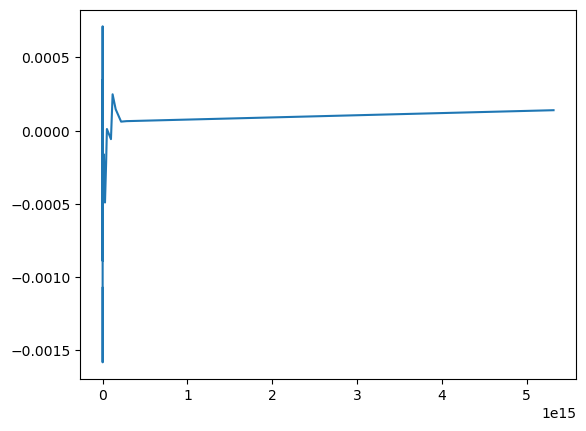

In [23]:
def compute_error(result):
    return integral_l - result

def error_esteem(evaluated_f, V):
    N = len(evaluated_f)
    variance = np.var(evaluated_f)
    error_estimate = V * np.sqrt(variance / N)
    return error_estimate

def fun(v):
    x, y, z = v
    return l(x, y, z)

N = 10000
maxiter = 30
sslhs = LHS(3).random(N)
scaledlhs = scale(sslhs, l_bounds=l_bounds, u_bounds=u_bounds)
tol = 1e-6

paindata = []
cerror = None
cerror_old = None
Mnext = ceil(N/10)
Mnext_old = 0


Ntot = N
# fsamples = np.apply_along_axis(fun, 1, scaledlhs)
# cerror = error_esteem(fsamples, V)
# paindata.append([N, cerror])
# Mnext = int((np.var(fsamples) * V**2) / (tol**2) - Ntot)
# print(Mnext)
mcpredict = MCSim(fun, scaledlhs, V)
cerror = compute_error(mcpredict)
paindata.append([N, cerror])

iter = 0
while abs(cerror) > tol and iter < maxiter:
    Ntot += Mnext 
    iter += 1
    cerror_old = cerror
    clear_output()
    print(iter, Mnext)
    if Mnext > 10000:
        print("THRESHOLD REACHED")
        Mnext = 10000
    expansion = eLHS(sslhs, Mnext)
    sslhs = np.concatenate((sslhs, expansion))
    scaledlhs = np.concatenate((scaledlhs, expansion))

    # fsamples = np.apply_along_axis(fun, 1, scaledlhs)
    # cerror = error_esteem(fsamples, V)

    mcpredict = MCSim(fun, scaledlhs, V)
    # mcpredict = V * np.mean(fsamples)

    cerror = compute_error(mcpredict)
    # cerror = error_esteem(fsamples, V)
    paindata.append([Ntot, cerror])
    
    Mnext = abs(((Ntot * (abs(cerror) - tol))/abs((abs(cerror_old) - abs(cerror))) - Ntot))
    # Mnext = int(discrepancy() / discrepancy_threshold * initial_samples)
    # Mnext = ceil(N/10)
    # Mnext = int((np.var(fsamples) * V**2) / (tol**2) - Ntot)

mcpredict = MCSim(fun, scaledlhs, V)
paindata = np.array(paindata)

print(paindata)
if iter < maxiter:
    print("DONE FOR RESULT")
else:
    print("DONE FOR ITERMAX")

print("RESULT: ", mcpredict)
print("error: ", cerror)

plt.plot(paindata[:, 0], paindata[:, 1])
plt.show()

In [18]:
from scipy.stats.qmc import discrepancy

def compute_error(result):
    return integral_l - result

def error_esteem(evaluated_f, V):
    N = len(evaluated_f)
    variance = np.var(evaluated_f)
    error_estimate = V * np.sqrt(variance / N)
    return error_estimate

def fun(v):
    x, y, z = v
    return l(x, y, z)

def additional_samples(points, discrepancy_threshold=0.005):
    return int(discrepancy(points, method="L2-star",workers=4) / discrepancy_threshold * len(points))

N = 1000
maxiter = 100
sslhs = LHS(3).random(N)
scaledlhs = scale(sslhs, l_bounds=l_bounds, u_bounds=u_bounds)
tol = 1e-3

paindata = []
cerror = None
cerror_old = None
Mnext = ceil(N/10)
Mnext_old = 0

Ntot = N
fsamples = np.apply_along_axis(fun, 1, scaledlhs)
cerror = error_esteem(fsamples, V)
paindata.append([N, cerror])
Mnext = additional_samples(scaledlhs)
print(Mnext)
# mcpredict = MCSim(fun, scaledlhs, V)
# paindata.append([N, mcpredict])
# cerror = compute_error(mcpredict)
# fun = np.vectorize(fun)
iter = 0
while abs(cerror) > tol and iter < maxiter:
    Ntot += Mnext 
    iter += 1
    # cerror_old = cerror
    # clear_output()
    print(iter, Mnext, cerror)
    if Mnext > 10000:
        print("THRESHOLD REACHED")
        Mnext = 10000
    expansion = eLHS(sslhs, Mnext)
    sslhs = np.concatenate((sslhs, expansion))
    scaledlhs = np.concatenate((scaledlhs, expansion))

    # fsamples = fun(scaledlhs)
    fsamples = np.apply_along_axis(fun, 1, scaledlhs)
    cerror = error_esteem(fsamples, V)

    # mcpredict = MCSim(fun, scaledlhs, V)
    # mcpredict = V * np.mean(fsamples)

    # cerror = compute_error(mcpredict)
    paindata.append([Ntot, cerror])
    
    Mnext = additional_samples(scaledlhs)
    # Mnext = ceil((Mnext * cerror)/(np.abs(cerror_old) - np.abs(cerror)))
    # Mnext = 1000
    # Mnext = int((np.var(fsamples) * V**2) / (tol**2) - Ntot)

mcpredict = MCSim(fun, scaledlhs, V)
paindata = np.array(paindata)

print(paindata)
if iter < maxiter:
    print("DONE FOR RESULT")
else:
    print("DONE FOR ITERMAX")

print("RESULT: ", mcpredict)
print("error: ", compute_error(mcpredict))

plt.plot(paindata[:, 0], paindata[:, 1])
plt.show()

992
1 992 0.013731990768072352
2 1512 0.00982222713058205
3 2050 0.007468758454301518
4 2577 0.0059497463719376965
5 2765 0.004909949070970478
6 3304 0.00423452925160945
7 3779 0.0037289695435038044
8 5901 0.003309208900622961
9 5326 0.0028764809655496886
10 5267 0.002599435524421492
11 7339 0.0023914401773527123
12 9440 0.002168373681844179
13 12758 0.001957319630550921
THRESHOLD REACHED
14 13292 0.0017936043232574426
THRESHOLD REACHED
15 11225 0.0016647050052545742
THRESHOLD REACHED
16 11312 0.0015635075220875152
THRESHOLD REACHED
17 10369 0.0014746894051666445
THRESHOLD REACHED


KeyboardInterrupt: 

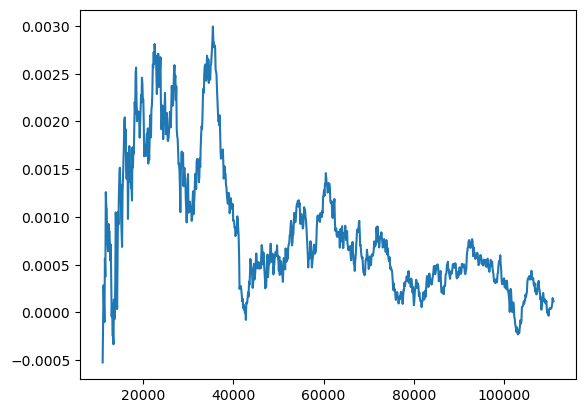

In [71]:

plt.plot(paindata[2:, 0], paindata[2:, 1])
plt.show()

In [69]:
integral_l - mcpredict

-3.9414822744499034e-07

# EXPERIMENT IV
Space filling properties

In [106]:
# data from exp1.1 P = 5
P = 2
considered_agents = n_agents
exp3data = exp1_agents
sps = {
    "eLHS": np.zeros((considered_agents, len(ms))),
    "eLHS-F": np.zeros((considered_agents, len(ms))),
    "LHS": np.zeros((considered_agents, len(ms))),
    "Sobol": np.zeros((considered_agents, len(ms)))
}
for i in range(considered_agents):
    sps["eLHS"][i, 0] = mindist(exp1_agents["eLHS"]["initial"][i])
    sps["eLHS-F"][i, 0] = mindist(exp1_agents["eLHS-F"]["initial"][i])
    sps["LHS"][i, 0] = mindist(exp1_agents["LHS"]["initial"][i])
    sps["Sobol"][i, 0] = mindist(exp1_agents["Sobol"]["initial"][i])
    for mindex in range(1, len(ms)):
        M = ms[mindex]
        sps["eLHS"][i, mindex] = mindist(concat(exp1_agents["eLHS"]["initial"][i], eLHS(exp1_agents["eLHS"]["initial"][i], M)))
        sps["eLHS-F"][i, mindex] = mindist(np.concatenate((exp1_agents["eLHS-F"]["initial"][i], *exp1_agents["eLHS-F"]["addons"][i, :mindex])))
        sps["LHS"][i, mindex] = mindist(np.concatenate((exp1_agents["LHS"]["initial"][i], *exp1_agents["LHS"]["addons"][i, :mindex])))
        sps["Sobol"][i, mindex] = mindist(np.concatenate((exp1_agents["LHS"]["initial"][i], *exp1_agents["Sobol"]["addons"][i, :mindex])))
    print("done:", str(i))

sps_final = {
    # "eLHS": np.average(sps["eLHS"], axis=0),
    "eLHS": np.average(sps["eLHS"], axis=0),
    "eLHS-F": np.average(sps["eLHS-F"], axis=0),
    "LHS": np.average(sps["LHS"], axis=0),
    "Sobol": np.average(sps["Sobol"], axis=0)
}



done: 0
done: 1
done: 2
done: 3
done: 4


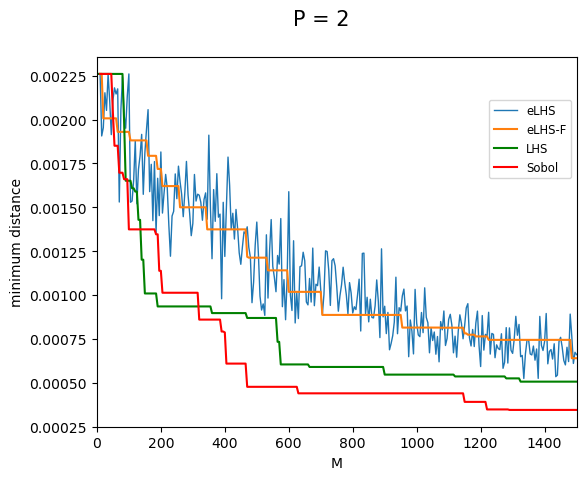

In [144]:

lw = 1.5
# plt.plot(ms, sps_final["eLHS"], linewidth=lw, label="eLHS", zorder=10)
plt.plot(ms, sps_final["eLHS"], linewidth=1, label="eLHS")
plt.plot(ms, sps_final["eLHS-F"], linewidth=lw, label="eLHS-F")
plt.plot(ms, sps_final["LHS"], linewidth=lw, label="LHS", color="green")
plt.plot(ms[1:], sps_final["Sobol"][1:], linewidth=lw, label="Sobol", color="red")
plt.xlim(0, Mmax)
plt.xlabel("M")
plt.ylabel("minimum distance")
plt.suptitle('P = ' + str(Ptot), fontsize=15)
# for K in range(1, K + 1):
#     plt.axvline(K * N, color='grey', linestyle='-', linewidth = 0.5)
plt.legend(bbox_to_anchor=(0.5, 0.4, 0.5, 0.5), fontsize='small')
plt.subplots_adjust(left=0.15)
# plt.savefig("./data/plots/exp4.1.mindistance.P_" + str(P) + ".png", dpi=500)
plt.show()

## Experiment 4.1
discrepancy evolution

In [48]:
from scipy.stats.qmc import discrepancy as discr
def discrepancy(points):
    return discr(points, method="L2-star", workers=4)

# data from exp1.1 P = 5
P = 2
considered_agents = n_agents
exp3data = exp1_agents
discrepancies = {
    "eLHS": np.zeros((considered_agents, len(ms))),
    "eLHS-F": np.zeros((considered_agents, len(ms))),
    "LHS": np.zeros((considered_agents, len(ms))),
    "Sobol": np.zeros((considered_agents, len(ms)))
}
for i in range(considered_agents):
    discrepancies["eLHS"][i, 0] = discrepancy(exp1_agents["eLHS"]["initial"][i])
    discrepancies["eLHS-F"][i, 0] = discrepancy(exp1_agents["eLHS-F"]["initial"][i])
    discrepancies["LHS"][i, 0] = discrepancy(exp1_agents["LHS"]["initial"][i])
    discrepancies["Sobol"][i, 0] = discrepancy(exp1_agents["Sobol"]["initial"][i])
    # discrepancies["LHS"][i, 0] = discrepancy(LHS(2).random(500))
    # discrepancies["Sobol"][i, 0] = discrepancy(LHS(2).random(500))
    for mindex in range(1, len(ms)):
        M = ms[mindex]
        discrepancies["eLHS"][i, mindex] = discrepancy(concat(exp1_agents["eLHS"]["initial"][i], eLHS(exp1_agents["eLHS"]["initial"][i], M)))
        discrepancies["eLHS-F"][i, mindex] = discrepancy(np.concatenate((exp1_agents["eLHS-F"]["initial"][i], *exp1_agents["eLHS-F"]["addons"][i, :mindex])))
        discrepancies["LHS"][i, mindex] = discrepancy(np.concatenate((exp1_agents["LHS"]["initial"][i], *exp1_agents["LHS"]["addons"][i, :mindex])))
        discrepancies["Sobol"][i, mindex] = discrepancy(np.concatenate((exp1_agents["Sobol"]["initial"][i], *exp1_agents["Sobol"]["addons"][i, :mindex])))
        # discrepancies["LHS"][i, mindex] = discrepancy(LHS(2).random(500 + M))
        # discrepancies["Sobol"][i, mindex] = discrepancy(Sobol(2).random(500 + M))
    print("done:", str(i))



done: 0
done: 1
done: 2
done: 3
done: 4


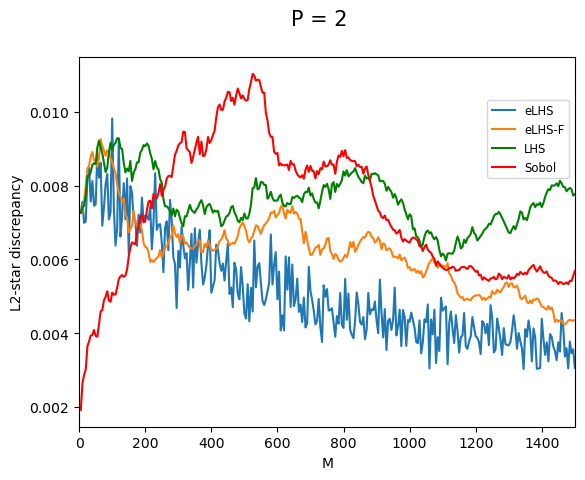

In [47]:

discrepancies_final = {
    "eLHS": np.average(discrepancies["eLHS"], axis=0),
    "eLHS-F": np.average(discrepancies["eLHS-F"], axis=0),
    "LHS": np.average(discrepancies["LHS"], axis=0),
    "Sobol": np.average(discrepancies["Sobol"], axis=0)
}
lw = 1.5
plt.plot(ms, discrepancies_final["eLHS"], linewidth=lw, label="eLHS")
plt.plot(ms, discrepancies_final["eLHS-F"], linewidth=lw, label="eLHS-F")
plt.plot(ms, discrepancies_final["LHS"], linewidth=lw, label="LHS",color="green")
plt.plot(ms, discrepancies_final["Sobol"], linewidth=lw, label="Sobol", color='red')
plt.xlim(0, Mmax)
plt.xlabel("M")
plt.ylabel("L2-star discrepancy")
plt.suptitle('P = ' + str(Ptot), fontsize=15)
# for K in range(1, K + 1):
#     plt.axvline(K * N, color='grey', linestyle='-', linewidth = 0.5)
plt.legend(bbox_to_anchor=(0.5, 0.4, 0.5, 0.5), fontsize='small')
plt.savefig("./data/plots/exp4.2.discrepancy.P_" + str(P) + ".png", dpi=500)
plt.show()

### EXPERIMENT III
Multivariate Gaussian distribution parameter estimation

In [7]:
from scipy.stats import norm

Nstart = 5000
itermax = 100
P = 2
step = 50


[[ 7.51163891]
 [15.09046066]
 [ 8.47530135]
 ...
 [ 6.83967215]
 [12.70898643]
 [ 5.71045661]]
0.0013217063811978846
Reason:  ACCURACY


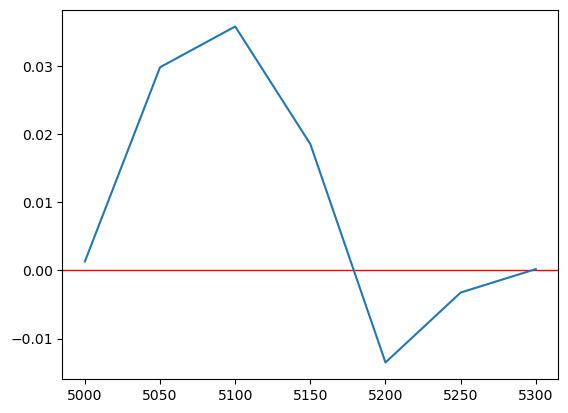

In [32]:
def compute_error(sampleset):
    return variance - np.cov(sampleset, rowvar=False)

error_threshold = 1e-3
mean = 10
variance = 9
vecppf = np.vectorize(lambda x: norm.ppf(x, loc=mean, scale=np.sqrt(variance)))

sslhs = LHS(1).random(Nstart)
exp3_elhs_results = []
# exp3_lhs_results = []

elhs_error_old = 0
elhs_error = None  # big num
elhs_agent = sslhs

next_stage = np.array([[]])
gauss_elhs = []
nextM = floor(Nstart/100)
nextM_old = 0

gauss_elhs = norm.ppf(elhs_agent, loc=mean, scale=np.sqrt(variance))
print(gauss_elhs)
elhs_error = compute_error(gauss_elhs)
print(elhs_error)
exp3_elhs_results.append([Nstart, elhs_error])

# print(gauss_elhs)

iter = 0 
total_samples = Nstart
while np.abs(elhs_error) >= error_threshold and iter < itermax :
    total_samples += nextM
    iter += 1
    # clear_output()
    # print(iter, nextM)
    next_stage = eLHS(elhs_agent, nextM)
    elhs_agent = np.concatenate([elhs_agent, next_stage])
    gauss_elhs = np.concatenate((gauss_elhs, norm.ppf(next_stage, loc=mean, scale=np.sqrt(variance))))
    elhs_error_old = elhs_error
    elhs_error = compute_error(gauss_elhs)

    exp3_elhs_results.append([total_samples, elhs_error])

    # ratio = abs(elhs_error_old - elhs_error)/nextM
    # nextM = ceil(np.abs(elhs_error) / ratio)
    # nextM = ceil(nextM - nextM / 15)

print("Reason: ", "ACCURACY" if np.abs(elhs_error) < error_threshold else "ITERATIONS")

# print(exp3_elhs_results)
exp3_elhs_results = np.array(exp3_elhs_results)
plt.axhline(0.0, color='red', linestyle='-', linewidth = 1.0, label = "Population")
plt.plot(exp3_elhs_results[:, 0], exp3_elhs_results[:, 1])
plt.show()

# ssmc = np.random.rand(N)
# gauss_mc = vecppf(ssmc)

# plt.scatter(xs, gauss, s=.1)
# plt.show()
# plt.hist(gauss_mc, density=True, bins=100, histtype='stepfilled', alpha=0.8)
# plt.legend(loc='best', frameon=False)
# plt.show()

# plt.hist(gauss_lhs, density=True, bins=100, histtype='stepfilled', alpha=.8)
# plt.legend(loc='best', frameon=False)
# plt.show()

# est_mean_mc = np.mean(gauss_mc, axis=0)
# est_cov_mc = np.cov(gauss_mc, rowvar=False)
# est_mean_lhs = np.mean(gauss_lhs, axis=0)
# est_cov_lhs = np.cov(gauss_lhs, rowvar=False)

# print("Real Mean:\n", mean)
# print("Real Covariance:\n", variance)
# print("-"*20)
# print("MC  | Estimated means: \n\t", est_mean_mc)
# print("MC  | Estimated covariance: \n\t", est_cov_mc)
# print("LHS | Estimated means: \n\t", est_mean_lhs)
# print("LHS | Estimated covariance: \n\t", est_cov_lhs)


### multivariate gaussian estimation

In [ ]:
from scipy.stats import norm, multivariate_normal

def multi_ppf(probabilities, mean, cov):
    """
    Compute the PPF for a multivariate normal distribution.

    Parameters:
    probabilities : array-like, shape (n,)
        Array of probabilities.
    mean : array-like, shape (d,)
        Mean of the multivariate normal distribution.
    cov : array-like, shape (d, d)
        Covariance matrix of the multivariate normal distribution.

    Returns:
    ppf : array, shape (d,)
        PPF (percent-point function) values corresponding to the input probabilities.
    """
    # Step 1: Compute the Cholesky decomposition of the covariance matrix
    L = np.linalg.cholesky(cov)
    
    # Step 2: Convert probabilities to standard normal quantiles
    standard_norm_quantiles = norm.ppf(probabilities)
    
    # Step 3: Transform to the desired multivariate normal distribution
    ppf = mean + L @ standard_norm_quantiles
    
    return ppf

N = 1000
P = 1
ssmc = MC(P).random(N)
sslhs = LHS(P).random(N)
mean = [0, 0]
cov = [[1, 8], 
       [8, 100]]

gauss_lhs = multi_ppf(ssmc, mean, cov)
gauss_lhs = multi_ppf(sslhs, mean, cov)

est_mean_mc = np.mean(gauss_mc, axis=0)
est_cov_mc = np.cov(gauss_mc, rowvar=False)
est_mean_lhs = np.mean(gauss_lhs, axis=0)
est_cov_lhs = np.cov(gauss_lhs, rowvar=False)

# print("Real Mean:\n", mean)
# print("Real Covariance:\n", variance)
# print("-"*20)
# print("MC  | Estimated means: \n\t", est_mean_mc)
# print("MC  | Estimated covariance: \n\t", est_cov_mc)
# print("LHS | Estimated means: \n\t", est_mean_lhs)
# print("LHS | Estimated covariance: \n\t", est_cov_lhs)



### mono-variate Gauss estimation

In [75]:
from scipy.stats import norm

error_threshold = 1e-9
N = 1000
P = 2
ssmc = np.random.rand(N)
sslhs = LHS(P).random(N)[:, 0]
mean = 10
variance = 9
vecppf = np.vectorize(lambda x: norm.ppf(x, loc=mean, scale=np.sqrt(variance)))
gauss_mc = vecppf(ssmc)
gauss_lhs = vecppf(sslhs)

# plt.scatter(xs, gauss, s=.1)
# plt.show()
# plt.hist(gauss_mc, density=True, bins=100, histtype='stepfilled', alpha=0.8)
# plt.legend(loc='best', frameon=False)
# plt.show()

# plt.hist(gauss_lhs, density=True, bins=100, histtype='stepfilled', alpha=.8)
# plt.legend(loc='best', frameon=False)
# plt.show()

est_mean_mc = np.mean(gauss_mc, axis=0)
est_cov_mc = np.cov(gauss_mc, rowvar=False)
est_mean_lhs = np.mean(gauss_lhs, axis=0)
est_cov_lhs = np.cov(gauss_lhs, rowvar=False)

print("Real Mean:\n", mean)
print("Real Covariance:\n", variance)
print("-"*20)
print("MC  | Estimated means: \n\t", est_mean_mc)
print("MC  | Estimated covariance: \n\t", est_cov_mc)
print("LHS | Estimated means: \n\t", est_mean_lhs)
print("LHS | Estimated covariance: \n\t", est_cov_lhs)


Real Mean:
 10
Real Covariance:
 9
--------------------
MC  | Estimated means: 
	 9.87903567239099
MC  | Estimated covariance: 
	 9.239490997884431
LHS | Estimated means: 
	 9.999192766018023
LHS | Estimated covariance: 
	 9.013281670199985
